#### Import necessary libs

In [161]:
import matplotlib.pyplot as plt

from applications.graph.graph_problem import GraphProblem
from classical_to_quantum.applications.graph.grover_applications.graph_oracle import *
from classical_to_quantum.algorithms.grover import GroverWrapper
from classical_to_quantum.applications.graph.grover_applications.graph_color import GraphColor
from classical_to_quantum.applications.graph.Ising import Ising
from qiskit_algorithms import GroverResult
from typing import List, Dict
import matplotlib.pyplot as plt
import networkx as nx
from classical_to_quantum.qasm_generate import QASMGenerator
from qiskit import qasm2


### Example: Independent Set
- 1. Grover algorithm, from IS to conjunctive normal formula, then construct an oracle from this cnf, then do a search
- 2. QAOA

In [162]:
graph_problem = GraphProblem("/Users/mac/workspace/quantum-journey/QUANTUM-CLASSICAL-TRANSLATION/classical_to_quantum/cases/Gset/G0")
independent_set_cnf = independent_set_to_sat(graph_problem.graph())
independent_set_oracle = cnf_to_quantum_oracle(independent_set_cnf)
def fun(state):
    return True
grover = GroverWrapper(oracle=independent_set_oracle,
                       iterations=2,
                       is_good_state=fun,
                       objective_qubits=list(range(graph_problem.num_nodes)))
is_res = grover.run(verbose=True)
top_measurements = is_res.top_measurement
print(top_measurements)

10
     ┌───┐┌────┐┌────┐
q_0: ┤ H ├┤0   ├┤0   ├
     ├───┤│    ││    │
q_1: ┤ H ├┤1   ├┤1   ├
     ├───┤│    ││    │
q_2: ┤ H ├┤2   ├┤2   ├
     ├───┤│    ││    │
q_3: ┤ H ├┤3   ├┤3   ├
     └───┘│    ││    │
q_4: ─────┤4   ├┤4   ├
          │  Q ││  Q │
q_5: ─────┤5   ├┤5   ├
          │    ││    │
q_6: ─────┤6   ├┤6   ├
          │    ││    │
q_7: ─────┤7   ├┤7   ├
          │    ││    │
q_8: ─────┤8   ├┤8   ├
          │    ││    │
q_9: ─────┤9   ├┤9   ├
          └────┘└────┘
c: 4/═════════════════
                      
{   'assignment': '0000',
    'circuit_results': [   {   '0000': 0.1406249999999966,
                               '0001': 0.1406249999999965,
                               '0010': 0.1406249999999962,
                               '0011': 0.0156249999999996,
                               '0100': 0.1406249999999961,
                               '0101': 0.0156249999999996,
                               '0110': 0.0156249999999996,
                             

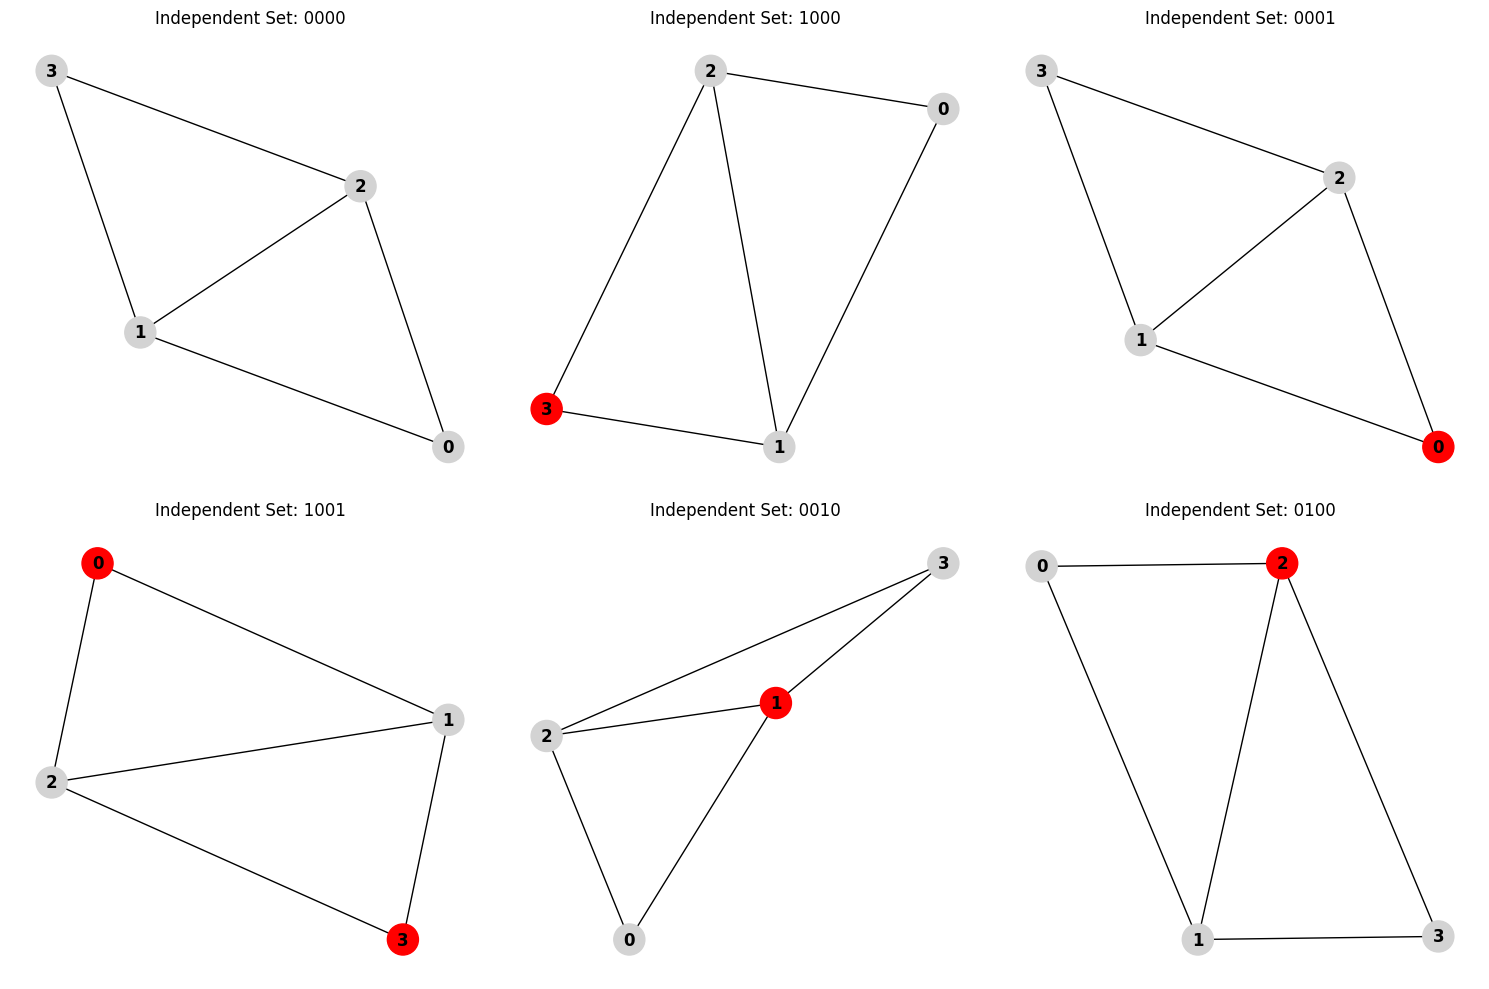

In [163]:
def get_top_measurements(result:GroverResult, threshold: float = 0.001, num: int = 3) -> List[Dict[str, float]]:
    """
    Get the top `num` measurements from the circuit results that differ within a given threshold.

    Parameters:
    - result: An object containing the assignment and circuit_results.
    - threshold (float): The threshold within which the measurement probabilities should differ.
    - num (int): The number of top measurements to return.

    Returns:
    - List[Dict[str, float]]: A list of dictionaries containing the top measurements that meet the threshold criteria.
    """
    # Extract the circuit results from the result object
    circuit_results = result.circuit_results
    
    # Find the highest probability in the circuit results
    max_prob = max(circuit_results[0].values())
    
    # Filter measurements that are within the threshold of the maximum probability
    filtered_measurements = []
    for measurement, probability in circuit_results[0].items():
        if abs(max_prob - probability) <= threshold:
            filtered_measurements.append({measurement: probability})
    
    # Sort the filtered measurements by probability in descending order
    filtered_measurements.sort(key=lambda x: list(x.values())[0], reverse=True)
    
    # Return only the top `num` measurements
    return filtered_measurements[:num]
def plot_graph_independent_set(G, is_assignment, ax):
    """
    Plot the graph highlighting the independent set based on the given assignment.

    Parameters:
    - G (networkx.Graph): The graph to be plotted.
    - is_assignment (str): A bitstring where '1' indicates a node is in the independent set and '0' indicates it is not.
    - ax (matplotlib.axes.Axes): The axis on which to plot the graph.
    """
    # Decode the independent set assignment
    independent_set = []
    for i, bit in enumerate(reversed(is_assignment)):  # Start from the right-hand side of the bitstring
        if bit == '1':
            independent_set.append(i)
    
    # Color nodes: red for nodes in the independent set, lightgray for others
    node_colors = ['red' if node in independent_set else 'lightgray' for node in G.nodes]
    
    # Plot the graph on the given axis
    pos = nx.spring_layout(G)  # Spring layout for better visualization
    nx.draw(G, pos, node_color=node_colors, with_labels=True, edge_color='black', node_size=500, font_weight='bold', ax=ax)
    
    # Highlight the nodes that are in the independent set
    nx.draw_networkx_nodes(G, pos, nodelist=independent_set, node_color='red', ax=ax)
    
    ax.set_title(f"Independent Set: {is_assignment}")

def plot_multiple_independent_sets(G, measurements, num_per_row=3):
    """
    Plot multiple independent set solutions in a grid layout.

    Parameters:
    - G (networkx.Graph): The graph to be plotted.
    - measurements (list of dict): A list of dictionaries containing bitstrings as keys.
    - num_per_row (int): The number of plots per row in the grid.
    """
    num_measurements = len(measurements)
    num_rows = (num_measurements + num_per_row - 1) // num_per_row  # Calculate the number of rows needed
    
    fig, axs = plt.subplots(num_rows, num_per_row, figsize=(5 * num_per_row, 5 * num_rows))
    axs = axs.flatten()  # Flatten the axes array for easy indexing

    for i, measurement in enumerate(measurements):
        is_assignment = list(measurement.keys())[0]  # Get the bitstring
        plot_graph_independent_set(G, is_assignment, ax=axs[i])
    
    # Remove any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

top_is_measurements = get_top_measurements(is_res, num=100)
plot_multiple_independent_sets(graph_problem.graph(), top_is_measurements)

### Example: graph coloring

In [164]:
coloring_problem = GraphColor("/Users/mac/workspace/quantum-journey/QUANTUM-CLASSICAL-TRANSLATION/classical_to_quantum/cases/Gset/G0", verbose=True)
coloring_grover_res = coloring_problem.search()

Variable Qubits: [0, 1, 2, 3, 4, 5, 6, 7]
Check Qubits: [8, 9, 10, 11, 12]
Disagree List: [[[0, 1], [2, 3]], [[0, 1], [4, 5]], [[2, 3], [4, 5]], [[2, 3], [6, 7]], [[4, 5], [6, 7]]]
Output Qubit: 13
14
      ┌───┐┌─────┐
 q_0: ┤ H ├┤0    ├
      ├───┤│     │
 q_1: ┤ H ├┤1    ├
      ├───┤│     │
 q_2: ┤ H ├┤2    ├
      ├───┤│     │
 q_3: ┤ H ├┤3    ├
      ├───┤│     │
 q_4: ┤ H ├┤4    ├
      ├───┤│     │
 q_5: ┤ H ├┤5    ├
      ├───┤│     │
 q_6: ┤ H ├┤6    ├
      ├───┤│   Q │
 q_7: ┤ H ├┤7    ├
      └───┘│     │
 q_8: ─────┤8    ├
           │     │
 q_9: ─────┤9    ├
           │     │
q_10: ─────┤10   ├
           │     │
q_11: ─────┤11   ├
           │     │
q_12: ─────┤12   ├
           │     │
q_13: ─────┤13   ├
           └─────┘
 c: 8/════════════
                  


In [165]:
def get_top_measurements(result, threshold: float = 0.001, num: int = 3) -> List[Dict[str, float]]:
    """
    Get the top `num` measurements from the circuit results that differ within a given threshold.

    Parameters:
    - result: An object containing the assignment and circuit_results.
    - threshold (float): The threshold within which the measurement probabilities should differ.
    - num (int): The number of top measurements to return.

    Returns:
    - List[Dict[str, float]]: A list of dictionaries containing the top measurements that meet the threshold criteria.
    """
    # Extract the circuit results from the result object
    circuit_results = result.circuit_results
    
    # Find the highest probability in the circuit results
    max_prob = max(circuit_results[0].values())
    
    # Filter measurements that are within the threshold of the maximum probability
    filtered_measurements = []
    for measurement, probability in circuit_results[0].items():
        if abs(max_prob - probability) <= threshold:
            filtered_measurements.append({measurement: probability})
    
    # Sort the filtered measurements by probability in descending order
    filtered_measurements.sort(key=lambda x: list(x.values())[0], reverse=True)
    
    # Return only the top `num` measurements
    return filtered_measurements[:num]
bitstring_results = get_top_measurements(coloring_grover_res)
bitstring_results
    

[{'00011000': 0.0118408203125005},
 {'00011011': 0.0118408203125005},
 {'00100111': 0.0118408203125005}]

Plotting for bitstring 00011000 with color assignment: {0: 'red', 1: 'green', 2: 'blue', 3: 'red'}
['red', 'green', 'blue', 'red']
{0: 'red', 1: 'green', 2: 'blue', 3: 'red'}


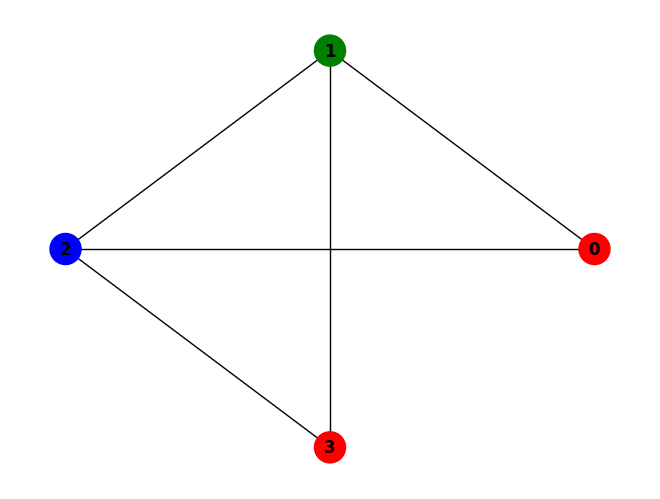

Plotting for bitstring 00011011 with color assignment: {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow'}
['red', 'green', 'blue', 'yellow']
{0: 'red', 1: 'green', 2: 'blue', 3: 'yellow'}


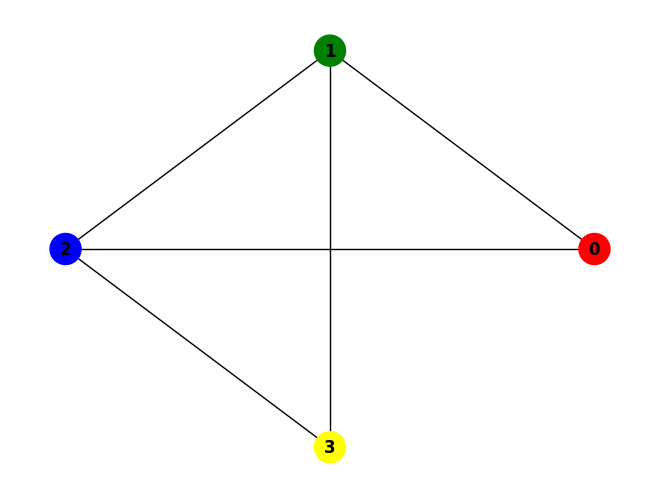

Plotting for bitstring 00100111 with color assignment: {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
['red', 'blue', 'green', 'yellow']
{0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}


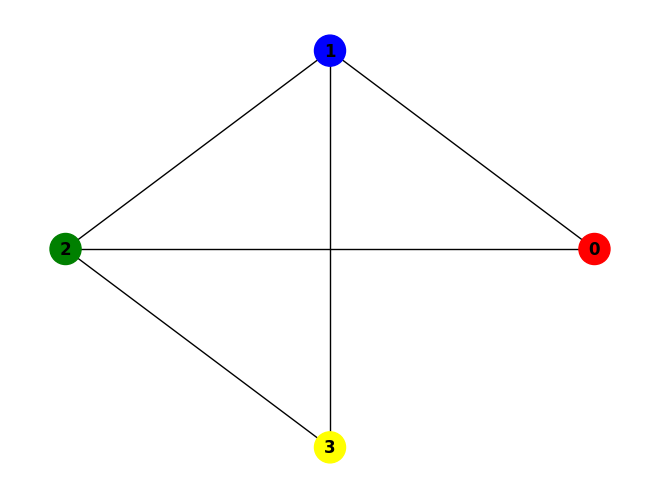

In [166]:
# Mapping from bit pairs to colors
color_map = {
    '00': 'red',    # Color 0
    '01': 'green',  # Color 1
    '10': 'blue',   # Color 2
    '11': 'yellow'  # Color 3
}

def plot_graph_coloring(G, color_assignment):
    """
    Plot the graph coloring using the provided color assignment.

    Parameters:
    - G (networkx.Graph): The graph to be colored.
    - color_assignment (dict): A dictionary mapping node indices to colors.
    """
    # Generate the node colors based on the assignment
    node_colors = [color_assignment[node] for node in G.nodes]
    print(node_colors)
    print(color_assignment)
    # Draw the graph with the assigned colors
    pos = nx.circular_layout(G)  # You can change the layout as needed
    nx.draw(G, pos, node_color=node_colors, with_labels=True, edge_color='black', node_size=500, font_weight='bold')
    plt.show()

def decode_bitstring_to_colors(bitstring):
    """
    Decode the bitstring into a color assignment based on the last two bits.

    Parameters:
    - bitstring (str): The bitstring representing the color assignment.

    Returns:
    - dict: A dictionary mapping node indices to color names.
    """
    n = len(bitstring) // 2  # Number of nodes
    color_assignment = {}
    
    for i in range(n):
        color_bits = bitstring[2 * i:2 * i + 2]  # Extract the bit pair for the i-th node
        color_assignment[i] = color_map[color_bits]  # Map the bit pair to the corresponding color
    
    return color_assignment


# Plot each graph coloring from the bitstring results
for result in bitstring_results:
    bitstring = list(result.keys())[0]
    color_assignment = decode_bitstring_to_colors(bitstring)
    print(f"Plotting for bitstring {bitstring} with color assignment: {color_assignment}")
    plot_graph_coloring(coloring_problem.graph(), color_assignment)

-- cannot find parameters matching version: , using: 22.1.1.0
-- cannot find parameters matching version: , using: 22.1.1.0


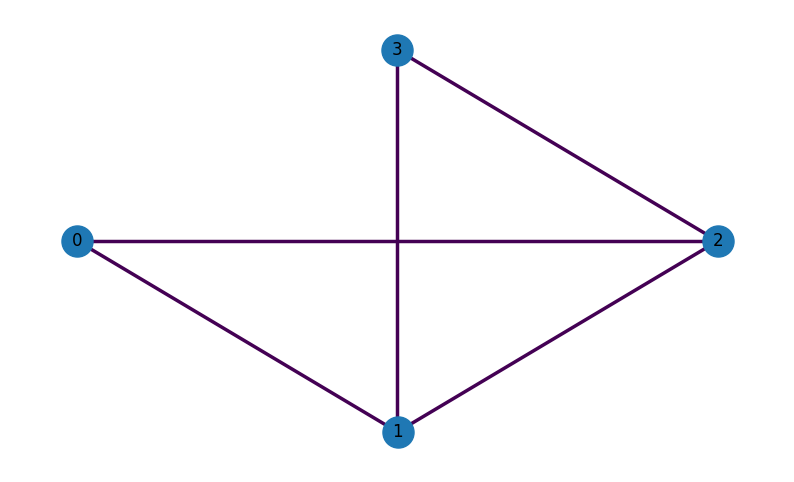

{'angles': [0.599737580852, 0.355196154168, 0.11915800009, 0.119989898795, 0.342657032466, 0.567311545998], 'cost': 2758.85, 'measurement_outcomes': {'0001001100110110': 1, '1011101110111010': 1, '1010111001010100': 1, '0000101001010101': 1, '0111110010100111': 1, '0110100111010000': 1, '0100011010110100': 1, '0001001111100001': 1, '1000101000101000': 1, '0010000101010011': 1, '0001111001000110': 1, '0101011000011011': 1, '0110010100111110': 1, '1000011101110100': 1, '1001111011001001': 1, '0100011100010010': 1, '1011101110110011': 1, '0100011010011100': 1, '0101100110000101': 1, '0111001111101100': 1, '0101101101111000': 1, '1110010001001101': 1, '1100001111001000': 1, '0001110100110001': 1, '0011011110100011': 1, '0001001100110011': 1, '0110101001010100': 1, '1111101010100101': 1, '0111000000001001': 1, '0101000010100101': 1, '0100101001001010': 1, '1101111101110010': 1, '1001101011110001': 1, '1111100010001100': 1, '1111011001100011': 1, '1011100100101011': 1, '0001111010010001': 1,

In [167]:
coloring_problem_ising = Ising(graph_problem.graph(), "KColor")
coloring_problem_ising.plot_graph()
plt.show()
result = coloring_problem_ising.run(verbose=True)
print(result.most_probable_states)

0001001100110110
Skipping invalid solution 1: 'c' argument has 7 elements, which is inconsistent with 'x' and 'y' with size 4.
Skipping invalid solution 2: 'c' argument has 11 elements, which is inconsistent with 'x' and 'y' with size 4.
Skipping invalid solution 3: 'c' argument has 8 elements, which is inconsistent with 'x' and 'y' with size 4.
Skipping invalid solution 4: 'c' argument has 6 elements, which is inconsistent with 'x' and 'y' with size 4.
Skipping invalid solution 5: 'c' argument has 10 elements, which is inconsistent with 'x' and 'y' with size 4.
Skipping invalid solution 6: 'c' argument has 7 elements, which is inconsistent with 'x' and 'y' with size 4.
Skipping invalid solution 7: 'c' argument has 7 elements, which is inconsistent with 'x' and 'y' with size 4.
Skipping invalid solution 8: 'c' argument has 7 elements, which is inconsistent with 'x' and 'y' with size 4.
Skipping invalid solution 9: 'c' argument has 5 elements, which is inconsistent with 'x' and 'y' with

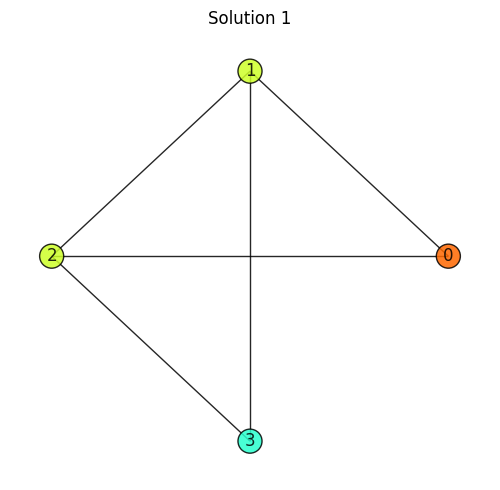

In [168]:
solutions = result.most_probable_states.get('solutions_bitstrings')
print(solutions[0])
def plot_first_20_valid_solutions(solutions, coloring_problem_ising):
    try:
        # Calculate the number of rows needed (up to 20 solutions, 3 per row)
        valid_solution_count = 0
        max_solutions = 3
        cols = 3
        rows = (max_solutions + cols - 1) // cols  # Ceiling division to determine the number of rows
        
        fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figure size based on number of rows

        # Flatten axs array in case of multiple rows/columns
        axs = axs.flatten()

        for i, solution in enumerate(solutions):
            if valid_solution_count >= max_solutions:
                break  # Stop after plotting 20 valid solutions

            try:
                ax = axs[valid_solution_count]  # Access the correct subplot
                # Plot each valid solution
                coloring_problem_ising.problem.plot_solution(solution, ax=ax)
                ax.set_title(f"Solution {valid_solution_count + 1}")
                valid_solution_count += 1  # Increment the valid solution counter
            except Exception as e:
                print(f"Skipping invalid solution {i + 1}: {e}")

        # Remove any unused subplots
        for j in range(valid_solution_count, len(axs)):
            fig.delaxes(axs[j])

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()  # Show the combined figure with all valid subplots
    
    except Exception as e:
        print(f"Error plotting solutions: {e}")
plot_first_20_valid_solutions(solutions, coloring_problem_ising)
    


In [2]:
independent_set_code = """
import itertools

def is_independent_set(graph, subset):
    # Check if the subset is an independent set
    for i in range(len(subset)):
        for j in range(i + 1, len(subset)):
            if graph[subset[i]][subset[j]] == 1:
                return False
    return True

def find_max_independent_set(graph):
    n = len(graph)
    nodes = list(range(n))
    max_independent_set = []

    # Check all possible subsets
    for size in range(1, n + 1):
        for subset in itertools.combinations(nodes, size):
            if is_independent_set(graph, subset):
                if len(subset) > len(max_independent_set):
                    max_independent_set = subset

    return max_independent_set

# Example usage:
# Adjacency matrix representation of the graph
graph = [
    [0, 1, 0, 0, 0],
    [1, 0, 1, 1, 0],
    [0, 1, 0, 0, 1],
    [0, 1, 0, 0, 1],
    [0, 0, 1, 1, 0]
]

max_independent_set = find_max_independent_set(graph)
print("Maximum Independent Set:", max_independent_set)
"""
from classical_to_quantum.qasm_generate import QASMGenerator
generator = QASMGenerator()
qasm_code = generator.qasm_generate(classical_code=independent_set_code, verbose=False)
grover_code = qasm_code.get('grover')
qaoa_code = qasm_code.get('qaoa')

print(grover_code)

[<class 'classical_to_quantum.applications.graph.Ising.Ising'>, <class 'classical_to_quantum.applications.graph.graph_problem.GraphProblem'>]
<class 'classical_to_quantum.applications.graph.Ising.Ising'>
-- cannot find parameters matching version: , using: 22.1.1.0
-- cannot find parameters matching version: , using: 22.1.1.0
<class 'classical_to_quantum.applications.graph.graph_problem.GraphProblem'>
OPENQASM 2.0;
include "qelib1.inc";
gate or q0,q1,q2 { x q2; x q0; x q1; ccx q0,q1,q2; x q0; x q1; }
gate or_6169966768 q0,q1,q2 { or q0,q1,q2; }
gate or_6169965088 q0,q1,q2 { or q0,q1,q2; }
gate or_6169965328 q0,q1,q2 { or q0,q1,q2; }
gate or_11436219696 q0,q1,q2 { or q0,q1,q2; }
gate or_11436933024 q0,q1,q2 { or q0,q1,q2; }
gate mcu1(param0) q0,q1,q2,q3,q4,q5 { cu1(pi/16) q4,q5; cx q4,q3; cu1(-pi/16) q3,q5; cx q4,q3; cu1(pi/16) q3,q5; cx q3,q2; cu1(-pi/16) q2,q5; cx q4,q2; cu1(pi/16) q2,q5; cx q3,q2; cu1(-pi/16) q2,q5; cx q4,q2; cu1(pi/16) q2,q5; cx q2,q1; cu1(-pi/16) q1,q5; cx q4,q1; c

In [4]:
from qiskit import qasm2
grover_circuit = qasm2.loads(grover_code, custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
qaoa_circuit = qasm2.loads(qaoa_code, custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
print(qaoa_circuit)
print(grover_circuit)

        ┌───┐                ┌───────┐   ┌─────────────┐                »
  q2_0: ┤ H ├─■──────────────┤ Rz(0) ├───┤ Rx(-1.1738) ├────────────────»
        ├───┤ │ZZ(0.11708)   └───────┘   └─────────────┘┌──────────────┐»
  q2_1: ┤ H ├─■─────────────■──────────────■────────────┤ Rz(-0.23417) ├»
        ├───┤               │ZZ(0.11708)   │            └──────────────┘»
  q2_2: ┤ H ├───────────────■──────────────┼──────────────■─────────────»
        ├───┤                              │ZZ(0.11708)   │             »
  q2_3: ┤ H ├──────────────────────────────■──────────────┼─────────────»
        ├───┤                                             │ZZ(0.11708)  »
  q2_4: ┤ H ├─────────────────────────────────────────────■─────────────»
        └───┘                                                           »
meas: 5/════════════════════════════════════════════════════════════════»
                                                                        »
«                                     

In [5]:
from classical_to_quantum.parser import ProblemParser
from classical_to_quantum.qasm_generate import QASMGenerator
import json
import utils

# Load the test cases from the JSON file
with open('/Users/mac/workspace/quantum-journey/QUANTUM-CLASSICAL-TRANSLATION/classical_to_quantum/cases/classical_cases/cases.json',
          'r') as f:
    data = json.load(f)

# Access and execute the code for the clique problem
clique_code = data['test_cases']['clique']
maxcut_code = data['test_cases']['maximum cut']
eigenvalue_code = data['test_cases']['eigenvalue']
svm_code = data['test_cases']['svm']
cnf_code = data['test_cases']['cnf']
addition_code = data['test_cases']['addition']
independent_set_code = data['test_cases']['independent set']
tsp_code = data['test_cases']['tsp']


parser = ProblemParser()
parser.parse_code(clique_code)
print(parser.problem_type, parser.specific_graph_problem, parser.data)

parser.parse_code(maxcut_code)
print(parser.problem_type, parser.specific_graph_problem, parser.data)


parser.parse_code(eigenvalue_code)
print(parser.problem_type, parser.specific_graph_problem, parser.data)
observable = utils.decompose_into_pauli(parser.data)
print(observable)

parser.parse_code(svm_code)
print(parser.problem_type, parser.specific_graph_problem, parser.data)


parser.parse_code(cnf_code)
print(parser.problem_type, parser.specific_graph_problem, parser.data)

parser.parse_code(addition_code)
print(parser.problem_type, parser.specific_graph_problem, parser.data)

# parser.parse_code(independent_set_code)
# print(independent_set_code)
# print(parser.problem_type, parser.specific_graph_problem, parser.data)
generator = QASMGenerator()
qasm_code = generator.qasm_generate(classical_code=independent_set_code, verbose=False)
print(qasm_code.get('grover'))

parser.parse_code(tsp_code)
print(parser.problem_type, parser.specific_graph_problem, parser.data)

ProblemType.GRAPH Clique Problem Graph with 5 nodes and 6 edges
ProblemType.GRAPH Max-Cut Problem Graph with 6 nodes and 8 edges
ProblemType.EIGENVALUE None [[-2  0  0 -5]
 [ 0  4  1  0]
 [ 0  1  4  0]
 [-5  0  0 -2]]
SparsePauliOp(['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ'],
              coeffs=[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -2.+0.j,  0.+0.j,  0.+0.j,
  0.+0.j,  0.+0.j,  3.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -3.+0.j])
ProblemType.MACHINELEARNING None None
ProblemType.CNF None [[-1, -2, -3], [1, -2, 3], [1, 2, -3], [1, -2, -3], [-1, 2, 3]]
None None None
[<class 'classical_to_quantum.applications.graph.Ising.Ising'>, <class 'classical_to_quantum.applications.graph.graph_problem.GraphProblem'>]
<class 'classical_to_quantum.applications.graph.Ising.Ising'>
-- cannot find parameters matching version: , using: 22.1.1.0
-- cannot find parameters matching version: , using: 22.1.1.0
<class 'classical_to_quantum.applica